In [3]:
#Añadir la raiz del proyecto temporal
import sys
sys.path.insert(0, "/home/ubuntu/projects/historical-analysis-management-tickets")

In [69]:
#dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import os
from collections import Counter
from src.configuraciones import configuracion_visual
from src.configuraciones import configuracion_format_df

In [5]:
#cargar dfs
folder_p = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed_SC"
df_all = pd.read_csv(f"{folder_p}/df_all.csv")

In [6]:
#configuracion
#visual
configuracion_visual()

#arreglo de datos
df_all = configuracion_format_df(df_all)

#vista de df
print("Dataframe cargado con éxito. Dimensiones:", df_all.shape)
print(f"Tickets disponibles: {df_all.shape[0]}")
print("Columnas disponibles:", df_all.columns.tolist())

Configurado visualmente
Configuracion fechas lista
Dataframe cargado con éxito. Dimensiones: (109796, 34)
Tickets disponibles: 109796
Columnas disponibles: ['Unnamed: 0', 'id', 'titulo', 'estado', 'ultima_modificacion', 'fecha_de_apertura', 'prioridad', 'solicitante__solicitante', 'asignado_a__grupo_de_tecnicos', 'asignado_a__tecnico', 'categoria', 'origen_de_la_solicitud', 'ubicacion', 'seguimientos__origen_de_la_solicitud', 'fecha_de_cierre', 'fecha_de_solucion', 'cumple_SLA', 'fecha_de_apertura_dia', 'fecha_de_apertura_mes', 'fecha_de_apertura_año', 'fecha_de_apertura_hora', 'fecha_de_apertura_periodo_mes', 'creado_en_horario_laboral', 'area', 'servicio', 'tiempo_vida_horas', 'prioridad_num', 'weekday', 'hour', 'es_sin_categoria', 'Estado Categoria', 'Estado Asignacion', 'Estado Asignacion grupal', 'Estado Asignacion Total']


In [7]:
#areas infra TI
areas_infra = ["DBA", "Ingenieros TI", "Técnico TI"]

#ingenieros del area
ingenieros = ["Orieta Catalan Ossandon (9)",
              "Cesar Milko Lazo Valencia (8)",
              "Gonzalo Alejandro Tobar Ramirez (17)",
              "Cesar Milko Lazo Valencia (8) <br>Orieta Catalan Ossandon (9)",
              "Cesar Milko Lazo Valencia (8) <br>Gonzalo Alejandro Tobar Ramirez (17)",
              "Jean Franco Andre Miranda Astudillo (14)",
              ""]

#filtro de llamadas o cosas de prueba (ruido)
servicio_prueba = ["Llamado de Prueba", "Llamado Cortado / Liberado", "Consulta Ticket"]

#flag de si es infra o no
df_all['es_infraestructura'] = ((df_all['area'].isin(areas_infra)) | 
                                (df_all["asignado_a__tecnico"].isin(ingenieros) & (df_all['area'] == "Sin Categoria")))

#df infra
df_infra = df_all[df_all['es_infraestructura']].copy()
n_ruido = df_infra[df_infra["servicio"].isin(servicio_prueba)].shape[0]

print(f"Total Tickets: {len(df_all)}")
print(f"Tickets Infraestructura (True): {len(df_infra)}")
print(f"Peso Operativo: {df_all['es_infraestructura'].mean()*100:.1f}% del total")
print(f"Ticket de infra TI con ruido: {n_ruido}")

df_infra = df_infra[~df_infra["servicio"].isin(servicio_prueba)]
print(f"Registros restantes: {len(df_infra)}")
print()

#tickets totales de infra TI por año
prueba = df_infra[df_infra["fecha_de_apertura_año"].between(2022,2025)]
print(prueba.groupby("fecha_de_apertura_año")["id"].count())


Total Tickets: 109796
Tickets Infraestructura (True): 36443
Peso Operativo: 33.2% del total
Ticket de infra TI con ruido: 0
Registros restantes: 36443

fecha_de_apertura_año
2022     1475
2023    12342
2024    11580
2025    11046
Name: id, dtype: int64


/tmp/ipykernel_274741/1752776598.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_perf, x='es_infraestructura', y='tiempo_vida_horas',
/tmp/ipykernel_274741/1752776598.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Otras Áreas (False)', 'Infraestructura TI (True)'])


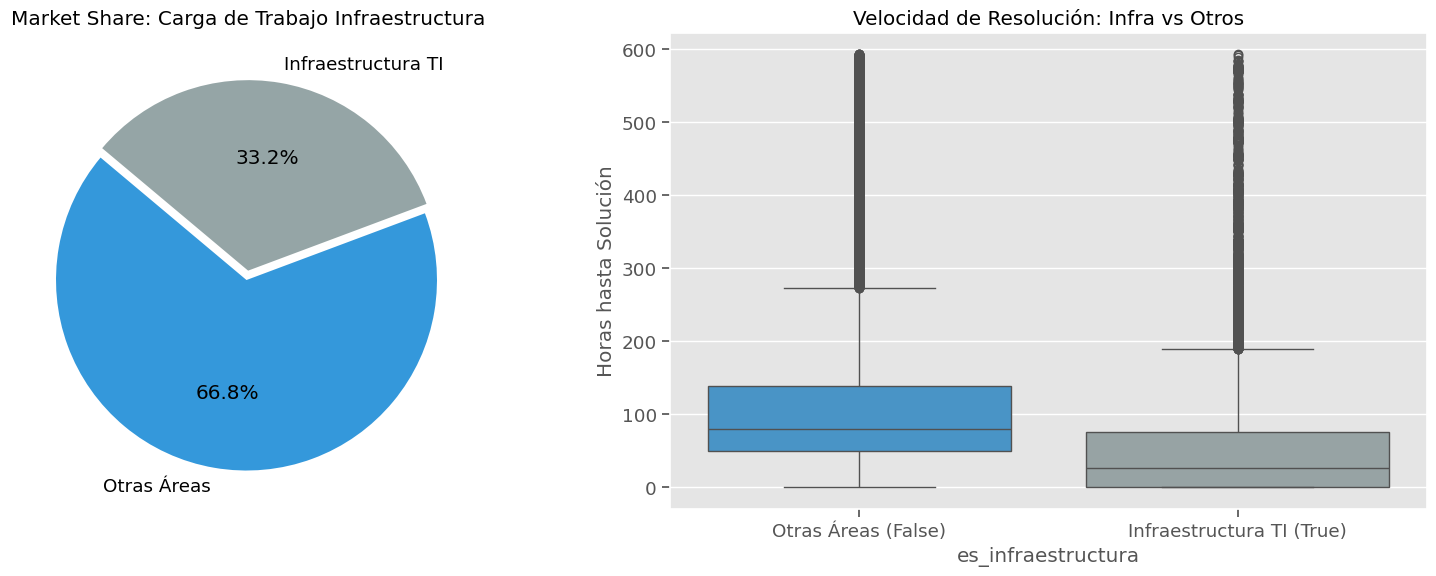

Tickets infra TI con mayor tiempo de Resolucion
                area                  servicio  tiempo_vida_horas
26787  Ingenieros TI  SCADA Infraestructura TI            9144.65
25774            DBA     Revisión Servicio SAP            8789.50
5730      Técnico TI                   General            8375.77
35519  Ingenieros TI  SCADA Infraestructura TI            6909.07
16415            DBA                   General            6198.27


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#grafico Distribucion de trabajo (pie chart)
conteo_macro = df_all['es_infraestructura'].value_counts()
labels_map = {True: 'Infraestructura TI', False: 'Otras Áreas'}
labels = [labels_map[x] for x in conteo_macro.index]

axes[0].pie(conteo_macro, labels=labels, autopct='%1.1f%%', 
            startangle=140, colors=['#3498db', '#95a5a6'], explode=(0.05, 0))
axes[0].set_title('Market Share: Carga de Trabajo Infraestructura')

#grafico velocidad de resolucion (boxplot)
#outliers <95
q95 = df_all['tiempo_vida_horas'].quantile(0.95)
df_perf = df_all[df_all['tiempo_vida_horas'] < q95]

sns.boxplot(data=df_perf, x='es_infraestructura', y='tiempo_vida_horas', 
            palette=['#3498db', '#95a5a6'], ax=axes[1])

axes[1].set_xticklabels(['Otras Áreas (False)', 'Infraestructura TI (True)'])
axes[1].set_title('Velocidad de Resolución: Infra vs Otros')
axes[1].set_ylabel('Horas hasta Solución')

plt.tight_layout()
plt.show()

df_pp = df_perf.sort_values("tiempo_vida_horas", ascending=False)
print("Tickets infra TI con mayor tiempo de Resolucion")
print(df_infra[["area","servicio", "tiempo_vida_horas"]].sort_values("tiempo_vida_horas",ascending=False).head(5))

/tmp/ipykernel_274741/514055610.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_global.values, y=top_global.index, palette='mako', ax=axes[0])


/tmp/ipykernel_274741/514055610.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_infra.values, y=top_infra.index, palette='mako', ax=axes[1])


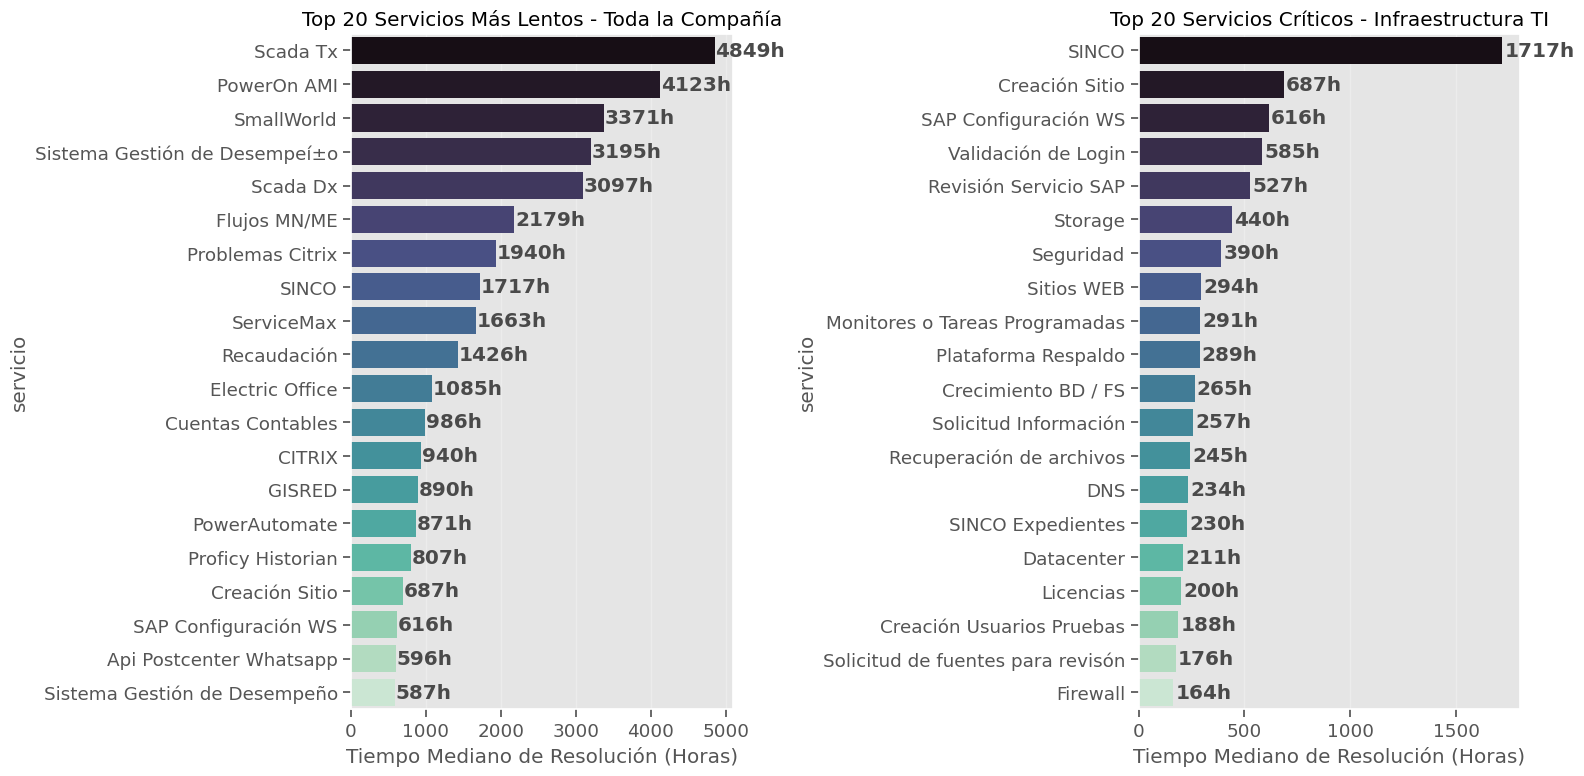

Interpretación:
El servicio más lento de Infraestructura ('SINCO') toma 71.5 días en resolverse (mediana).


In [9]:
#tiempos de resolucion mayores global vs infra TI
num=20
top_global = df_all.groupby('servicio')['tiempo_vida_horas'].median().sort_values(ascending=False).head(num)
top_infra = df_infra.groupby('servicio')['tiempo_vida_horas'].median().sort_values(ascending=False).head(num)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico izq global
sns.barplot(x=top_global.values, y=top_global.index, palette='mako', ax=axes[0])
axes[0].set_title(f'Top {num} Servicios Más Lentos - Toda la Compañía')
axes[0].set_xlabel('Tiempo Mediano de Resolución (Horas)')
axes[0].grid(True, axis='x', alpha=0.3)

for i, v in enumerate(top_global.values):
    axes[0].text(v + 10, i, f"{v:.0f}h", va='center', fontweight='bold', color='#4a4a4a')

# Gráfico der infra TI
sns.barplot(x=top_infra.values, y=top_infra.index, palette='mako', ax=axes[1])
axes[1].set_title(f'Top {num} Servicios Críticos - Infraestructura TI')
axes[1].set_xlabel('Tiempo Mediano de Resolución (Horas)')
axes[1].grid(True, axis='x', alpha=0.3)

for i, v in enumerate(top_infra.values):
    axes[1].text(v + 10, i, f"{v:.0f}h", va='center', fontweight='bold', color='#4a4a4a')

plt.tight_layout()
plt.show()

print("Interpretación:")
print(f"El servicio más lento de Infraestructura ('{top_infra.index[0]}') toma {top_infra.values[0]/24:.1f} días en resolverse (mediana).")


--- KPIs de Sub-Áreas (Infraestructura) ---
               Volumen  Tiempo_Mediana  Tecnicos_Activos  Tickets_por_Tecnico
area                                                                         
DBA              27412            5.00                84               326.30
Ingenieros TI     4951           64.20               112                44.20
Técnico TI        2808           87.70                64                43.90
Sin Categoria     1272           71.60                 5               254.40


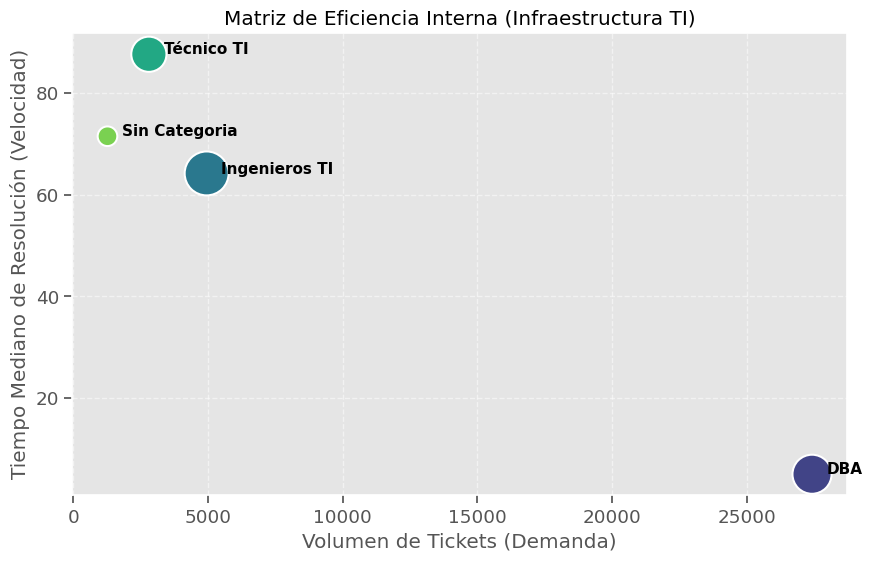

In [10]:
#KPIs del area
kpis_infra = df_infra.groupby('area').agg(
    Volumen=('id', 'count'),
    Tiempo_Mediana=('tiempo_vida_horas', 'median'),
    Tecnicos_Activos=('asignado_a__tecnico', 'nunique')
).sort_values('Volumen', ascending=False)

# Métricas derivadas
kpis_infra['Tickets_por_Tecnico'] = kpis_infra['Volumen'] / kpis_infra['Tecnicos_Activos']

print("\n--- KPIs de Sub-Áreas (Infraestructura) ---")
print(kpis_infra.round(1))

# --- Gráfico 3.1: Matriz de Eficiencia (Bubble Chart) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=kpis_infra, x='Volumen', y='Tiempo_Mediana', 
                size='Tecnicos_Activos', sizes=(200, 1000), 
                hue=kpis_infra.index, palette='viridis', legend=False)

# Etiquetas de texto
for i in range(kpis_infra.shape[0]):
    x = kpis_infra['Volumen'].iat[i]
    y = kpis_infra['Tiempo_Mediana'].iat[i]
    label = kpis_infra.index[i]
    plt.text(x + (kpis_infra['Volumen'].max()*0.02), y, label, weight='bold', fontsize=11)

plt.title('Matriz de Eficiencia Interna (Infraestructura TI)')
plt.xlabel('Volumen de Tickets (Demanda)')
plt.ylabel('Tiempo Mediano de Resolución (Velocidad)') # Cuanto más bajo, mejor
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


KPIs de Sub-Áreas (Infraestructura)
               Volumen  Tiempo_Mediana  Tecnicos_Activos  Tickets_por_Tecnico
area                                                                         
DBA               8582            0.20                34               252.40
Ingenieros TI     1788           43.30                64                27.90
Técnico TI         612           92.90                22                27.80
Sin Categoria       64           68.70                 2                32.00


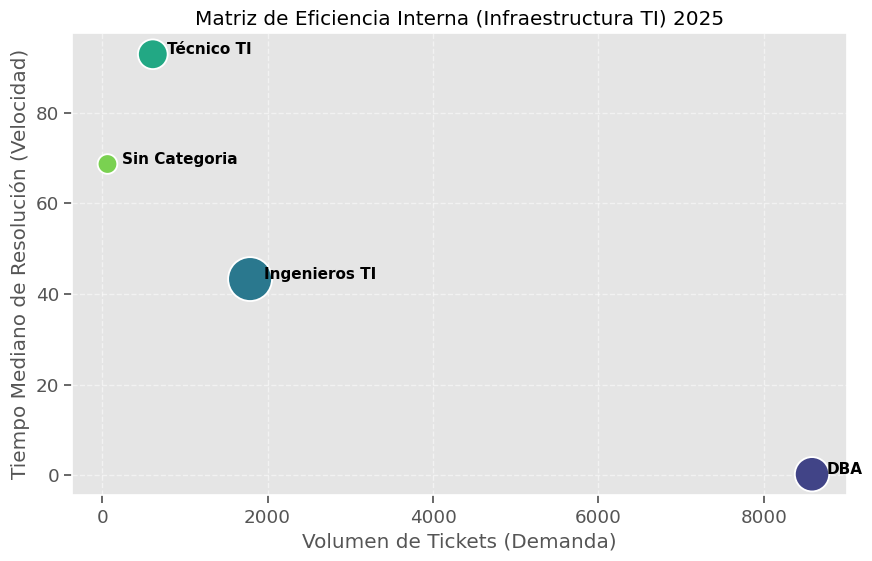

In [11]:
#KPIs del area 2025
kpis_infra = df_infra[df_infra["fecha_de_apertura_año"] == 2025].groupby('area').agg(
    Volumen=('id', 'count'),
    Tiempo_Mediana=('tiempo_vida_horas', 'median'),
    Tecnicos_Activos=('asignado_a__tecnico', 'nunique')
).sort_values('Volumen', ascending=False)

# Métricas derivadas
kpis_infra['Tickets_por_Tecnico'] = kpis_infra['Volumen'] / kpis_infra['Tecnicos_Activos']

print("\nKPIs de Sub-Áreas (Infraestructura)")
print(kpis_infra.round(1))

# --- Gráfico 3.1: Matriz de Eficiencia (Bubble Chart) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=kpis_infra, x='Volumen', y='Tiempo_Mediana', 
                size='Tecnicos_Activos', sizes=(200, 1000), 
                hue=kpis_infra.index, palette='viridis', legend=False)

# Etiquetas de texto
for i in range(kpis_infra.shape[0]):
    x = kpis_infra['Volumen'].iat[i]
    y = kpis_infra['Tiempo_Mediana'].iat[i]
    label = kpis_infra.index[i]
    plt.text(x + (kpis_infra['Volumen'].max()*0.02), y, label, weight='bold', fontsize=11)

plt.title('Matriz de Eficiencia Interna (Infraestructura TI) 2025')
plt.xlabel('Volumen de Tickets (Demanda)')
plt.ylabel('Tiempo Mediano de Resolución (Velocidad)') # Cuanto más bajo, mejor
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [21]:
top_tecnicos2025 = df_infra[(df_infra["fecha_de_apertura_año"] == 2025)]["asignado_a__tecnico"].value_counts().head(10)


asignado_a__tecnico
Gonzalo Alejandro Tobar Ramirez (17)        5967
Orieta Catalan Ossandon (9)                 1683
Cesar Milko Lazo Valencia (8)                841
Claudio Daniel Aliste Requena (3825)         495
Rodrigo Andres Jara Gutierrez (10)           429
Jean Franco Andre Miranda Astudillo (14)     320
Jocelyn Karina Ossandon Gonzalez (3681)      298
Fernando Basilio Layana Layana (3899)        237
Rodrigo Aravena Valdes (12)                  133
Esteban Francisco Cartes Riffo (4017)        112
Name: count, dtype: int64

/tmp/ipykernel_274741/1045834672.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_tecnicos.values, y=top_tecnicos.index, palette='mako')


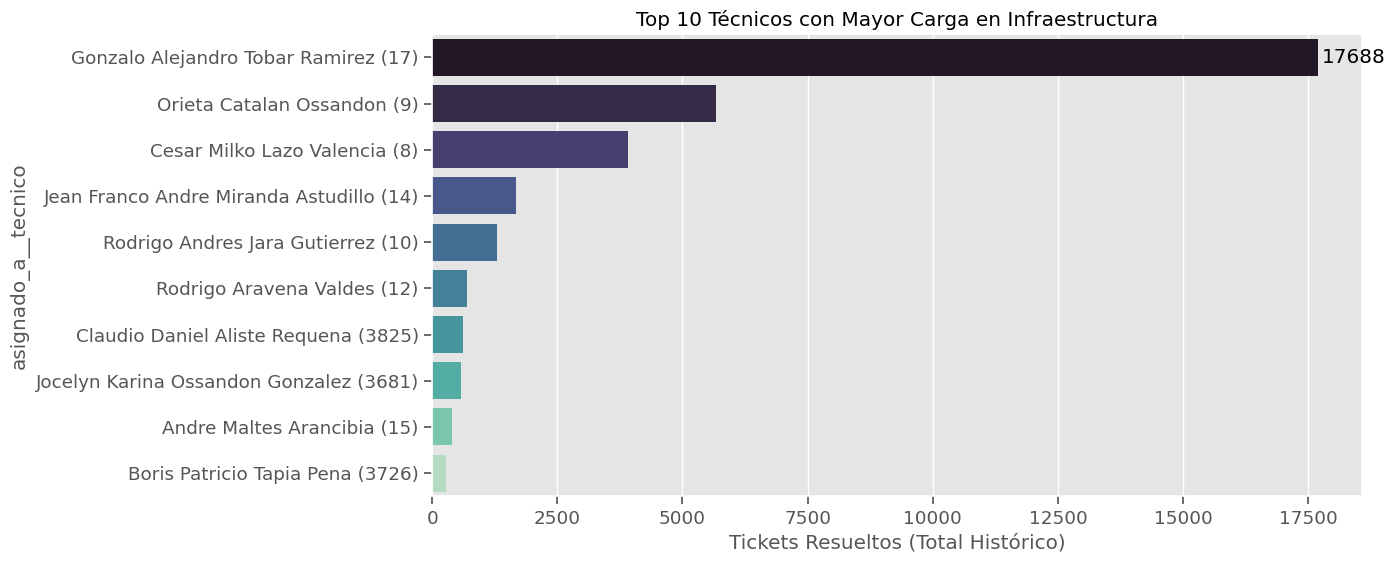

/tmp/ipykernel_274741/1045834672.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_tecnicos2025.values, y=top_tecnicos2025.index, palette='mako')


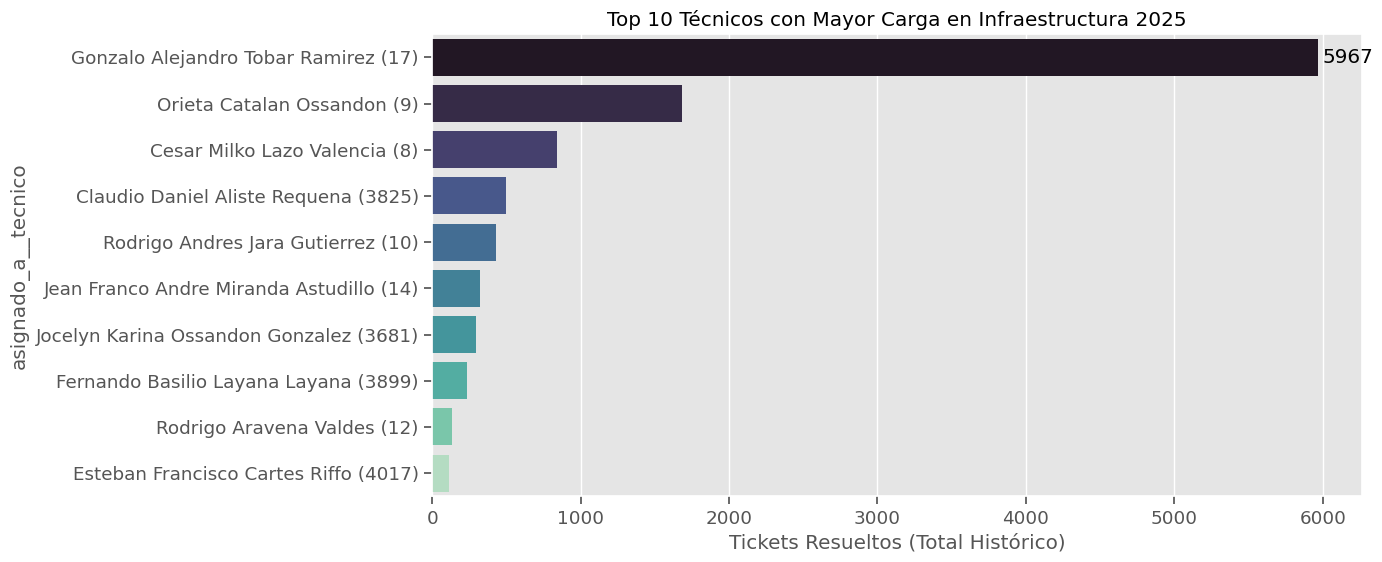

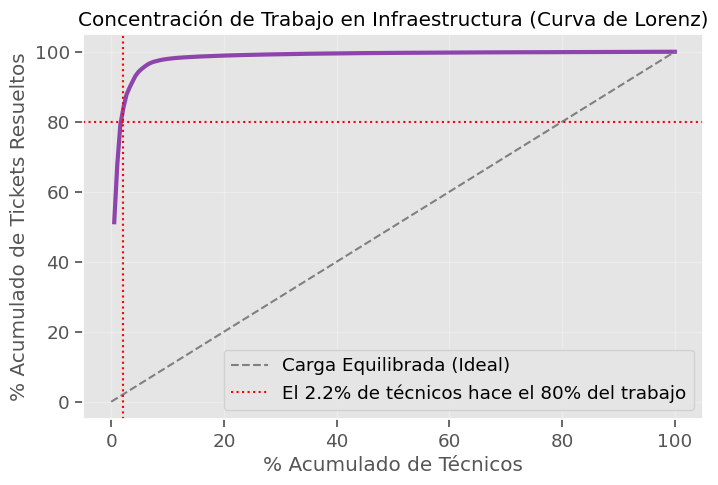

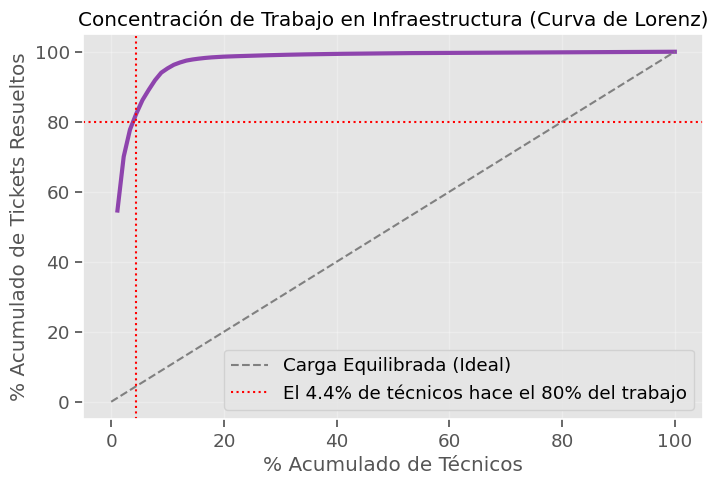

In [22]:
# Top 10 Técnicos de Infraestructura general
top_tecnicos = df_infra['asignado_a__tecnico'].value_counts().head(10)

#top ingenieros 2025
top_tecnicos2025 = df_infra[(df_infra["fecha_de_apertura_año"] == 2025)]["asignado_a__tecnico"].value_counts().head(10)

#grafico global
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=top_tecnicos.values, y=top_tecnicos.index, palette='mako')
plt.title('Top 10 Técnicos con Mayor Carga en Infraestructura')
plt.xlabel('Tickets Resueltos (Total Histórico)')
plt.bar_label(barplot.containers[0], padding=3)
plt.show()

#grafico 2025
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=top_tecnicos2025.values, y=top_tecnicos2025.index, palette='mako')
plt.title('Top 10 Técnicos con Mayor Carga en Infraestructura 2025')
plt.xlabel('Tickets Resueltos (Total Histórico)')
plt.bar_label(barplot.containers[0], padding=3)
plt.show()

# Curva de Lorenz (Concentración de Trabajo) global
cargas = df_infra['asignado_a__tecnico'].value_counts().values
cargas_ordenadas = np.sort(cargas)[::-1] # De mayor a menor
acumulado_tickets = np.cumsum(cargas_ordenadas) / cargas.sum() * 100
percentil_tecnicos = np.arange(1, len(cargas) + 1) / len(cargas) * 100

plt.figure(figsize=(8, 5))
plt.plot(percentil_tecnicos, acumulado_tickets, color='#8e44ad', linewidth=3)
plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='Carga Equilibrada (Ideal)')

# Punto de corte 80% (Pareto)
idx_pareto = np.argmax(acumulado_tickets >= 80)
pareto_x = percentil_tecnicos[idx_pareto]

plt.axvline(pareto_x, color='red', linestyle=':', label=f'El {pareto_x:.1f}% de técnicos hace el 80% del trabajo')
plt.axhline(80, color='red', linestyle=':')

plt.title('Concentración de Trabajo en Infraestructura (Curva de Lorenz)')
plt.xlabel('% Acumulado de Técnicos')
plt.ylabel('% Acumulado de Tickets Resueltos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Curva de Lorenz (Concentración de Trabajo) 2025
cargas = df_infra[(df_infra["fecha_de_apertura_año"] == 2025)]["asignado_a__tecnico"].value_counts().values
cargas_ordenadas = np.sort(cargas)[::-1] # De mayor a menor
acumulado_tickets = np.cumsum(cargas_ordenadas) / cargas.sum() * 100
percentil_tecnicos = np.arange(1, len(cargas) + 1) / len(cargas) * 100

plt.figure(figsize=(8, 5))
plt.plot(percentil_tecnicos, acumulado_tickets, color='#8e44ad', linewidth=3)
plt.plot([0, 100], [0, 100], linestyle='--', color='gray', label='Carga Equilibrada (Ideal)')

# Punto de corte 80% (Pareto)
idx_pareto = np.argmax(acumulado_tickets >= 80)
pareto_x = percentil_tecnicos[idx_pareto]

plt.axvline(pareto_x, color='red', linestyle=':', label=f'El {pareto_x:.1f}% de técnicos hace el 80% del trabajo')
plt.axhline(80, color='red', linestyle=':')

plt.title('Concentración de Trabajo en Infraestructura (Curva de Lorenz)')
plt.xlabel('% Acumulado de Técnicos')
plt.ylabel('% Acumulado de Tickets Resueltos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
#analisis trabajo manual DBA Scripts
tk_gt = df_infra[df_infra["asignado_a__tecnico"] == "Gonzalo Alejandro Tobar Ramirez (17)"].sort_values("tiempo_vida_horas", ascending=False)
gt2025 = tk_gt[tk_gt["fecha_de_apertura_año"] == 2025]
gt2025[["area","estado","fecha_de_apertura_año","tiempo_vida_horas"]].head(10)

,area,estado,fecha_de_apertura_año,tiempo_vida_horas
90290,DBA,Cerrado,2025,669.97
104158,DBA,Cerrado,2025,191.00
82962,Técnico TI,Cerrado,2025,161.57
82963,Técnico TI,Cerrado,2025,161.13
82965,Técnico TI,Cerrado,2025,160.87
90557,DBA,Cerrado,2025,145.58
83082,Técnico TI,Cerrado,2025,137.85
76490,Técnico TI,Cerrado,2025,122.72
89210,DBA,Cerrado,2025,117.47
102088,DBA,Cerrado,2025,109.23


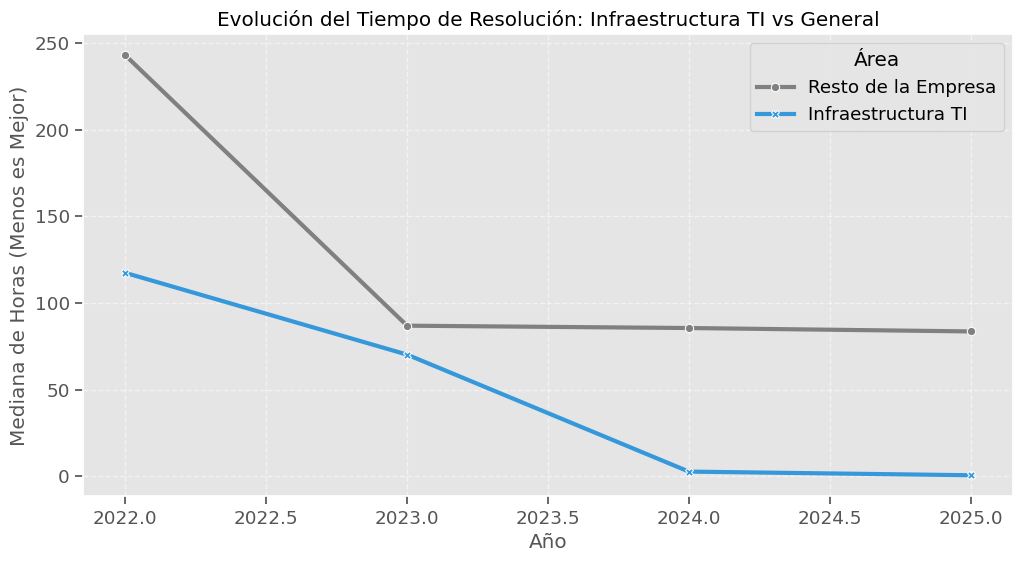

In [14]:
hago que #analisis historico de tickets en infra TI
df_evolucion = df_all[df_all["fecha_de_apertura_año"].between(2022, 2025)].copy()

trend_general = df_evolucion.groupby(['fecha_de_apertura_año', 'es_infraestructura'])['tiempo_vida_horas'].median().unstack()
trend_general.columns = ['Resto de la Empresa', 'Infraestructura TI']

plt.figure(figsize=(12, 6))
# Lineplot
sns.lineplot(data=trend_general, markers=True, dashes=False, linewidth=3, palette=['gray', '#3498db'])

plt.title('Evolución del Tiempo de Resolución: Infraestructura TI vs General')
plt.ylabel('Mediana de Horas (Menos es Mejor)')
plt.xlabel('Año')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Área')
plt.show()

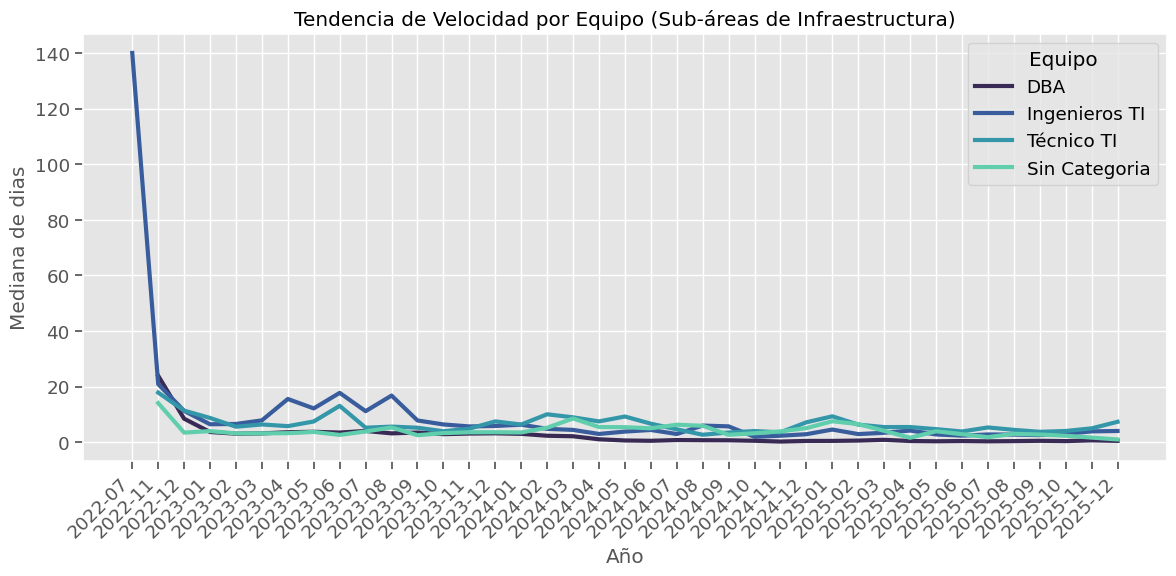

In [15]:
#Analisis evolutivo de subareas
df_infra_evo = df_evolucion[df_evolucion['es_infraestructura']].copy()

# Agrupamos por Año y Área Específica
trend_areas = df_infra_evo.groupby(["fecha_de_apertura_periodo_mes", 'area'])['tiempo_vida_horas'].mean().unstack()

trend_long = trend_areas.reset_index().melt(
    id_vars='fecha_de_apertura_periodo_mes',
    var_name='area',
    value_name='tiempo_vida_horas'
)

# convertir fecha y valores
trend_long['fecha_de_apertura_periodo_mes'] = trend_long['fecha_de_apertura_periodo_mes'].astype(str)
trend_long = trend_long.sort_values('fecha_de_apertura_periodo_mes')

plt.figure(figsize=(12,6))
sns.lineplot(data=trend_long,
             x='fecha_de_apertura_periodo_mes',
             y=trend_long['tiempo_vida_horas']/24,
             hue='area',
             markers=True, dashes=False, linewidth=3, palette='mako')
plt.xticks(rotation=45, ha='right')
plt.legend( loc='upper right', title='Equipo')
plt.title('Tendencia de Velocidad por Equipo (Sub-áreas de Infraestructura)')
plt.ylabel('Mediana de dias')
plt.xlabel('Año')
plt.tight_layout()
plt.show()

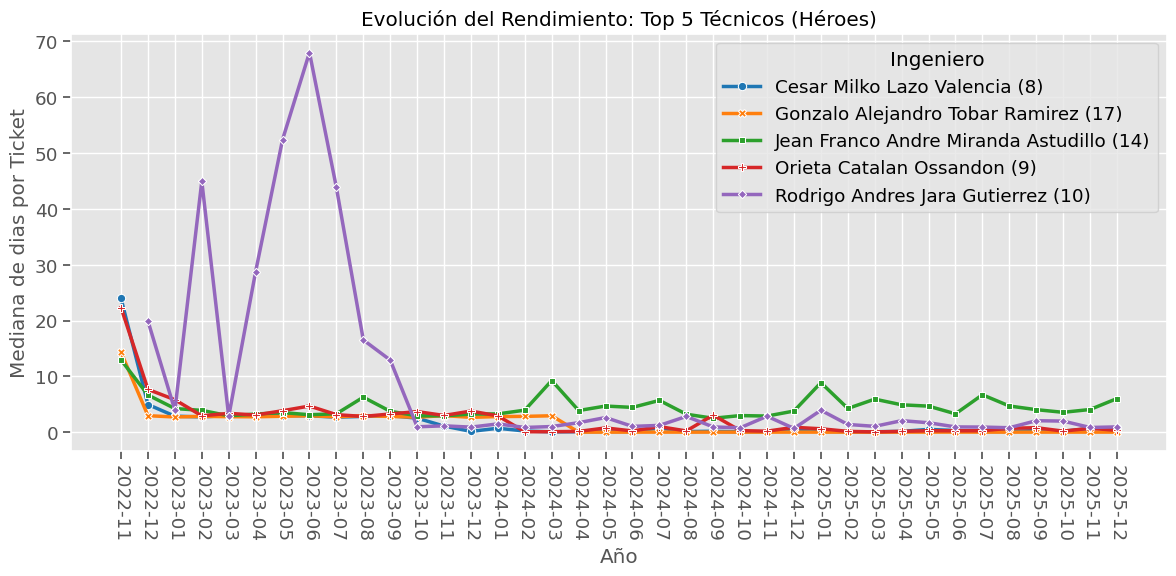

In [16]:
# top 5 ingenieros
top_5_tecnicos = df_infra_evo['asignado_a__tecnico'].value_counts().head(5).index.tolist()

# filtro
df_heroes = df_infra_evo[df_infra_evo['asignado_a__tecnico'].isin(top_5_tecnicos)]
df_heroes['fecha_de_apertura_periodo_mes'] = df_heroes['fecha_de_apertura_periodo_mes'].astype(str)
df_heroes['tiempo_vida_horas'] = df_heroes['tiempo_vida_horas']/24

# evolucion de tecnicos
trend_heroes = df_heroes.groupby(['fecha_de_apertura_periodo_mes', 'asignado_a__tecnico'])['tiempo_vida_horas'].median().unstack()

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_heroes, markers=True, dashes=False, linewidth=2.5, palette='tab10')

plt.title('Evolución del Rendimiento: Top 5 Técnicos (Héroes)')
plt.ylabel('Mediana de dias por Ticket')
plt.xlabel('Año')
plt.xticks(rotation=-90)
plt.legend(loc='upper right', title='Ingeniero')
plt.tight_layout()
plt.show()

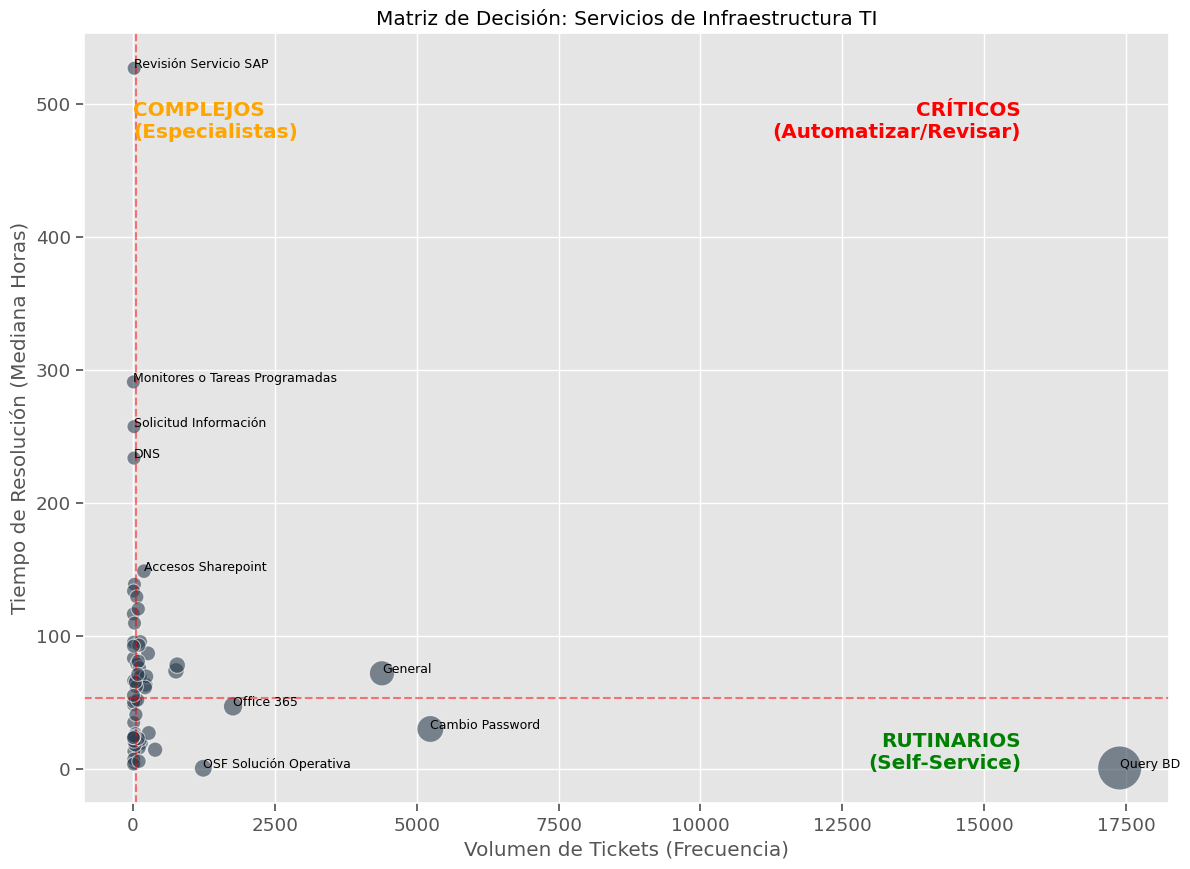

In [17]:
#POSIBLES RAMAS DE INVESTIGACION

#posibilidades de automatizacion
df_infra = df_all[df_all['es_infraestructura']].copy()

#matriz de servicios
kpis_servicios = df_infra.groupby('servicio').agg(
    Volumen=('id', 'count'),
    Tiempo_Mediana=('tiempo_vida_horas', 'median')
).reset_index()

#filtro de servicios con muy pocos datos (ruido)
umbral_corte = 10 
kpis_servicios = kpis_servicios[kpis_servicios['Volumen'] > umbral_corte]

#puntos medios de division
mediana_vol = kpis_servicios['Volumen'].median()
mediana_tiempo = kpis_servicios['Tiempo_Mediana'].median()

plt.figure(figsize=(14, 10))
sns.scatterplot(data=kpis_servicios, x='Volumen', y='Tiempo_Mediana', 
                size='Volumen', sizes=(100, 1000), alpha=0.6, color='#2c3e50', legend=False)

# Líneas de Cuadrantes
plt.axvline(mediana_vol, color='red', linestyle='--', alpha=0.5)
plt.axhline(mediana_tiempo, color='red', linestyle='--', alpha=0.5)

# Etiquetas de Cuadrantes
plt.text(kpis_servicios['Volumen'].max()*0.9, kpis_servicios['Tiempo_Mediana'].max()*0.9, 
         'CRÍTICOS\n(Automatizar/Revisar)', color='red', weight='bold', ha='right')
plt.text(kpis_servicios['Volumen'].min(), kpis_servicios['Tiempo_Mediana'].max()*0.9, 
         'COMPLEJOS\n(Especialistas)', color='orange', weight='bold', ha='left')
plt.text(kpis_servicios['Volumen'].max()*0.9, 0, 
         'RUTINARIOS\n(Self-Service)', color='green', weight='bold', ha='right')

# Etiquetar los servicios más extremos (Top 5 Volumen y Top 5 Tiempo)
top_vol = kpis_servicios.nlargest(5, 'Volumen')
top_time = kpis_servicios.nlargest(5, 'Tiempo_Mediana')
textos_a_mostrar = pd.concat([top_vol, top_time]).drop_duplicates()

for _, row in textos_a_mostrar.iterrows():
    plt.text(row['Volumen']+2, row['Tiempo_Mediana'], row['servicio'], fontsize=9)

plt.title('Matriz de Decisión: Servicios de Infraestructura TI')
plt.xlabel('Volumen de Tickets (Frecuencia)')
plt.ylabel('Tiempo de Resolución (Mediana Horas)')
plt.show()

In [24]:
df_infra.info()

<class 'pandas.DataFrame'>
Index: 36443 entries, 4 to 109797
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            36443 non-null  int64         
 1   id                                    36443 non-null  int64         
 2   titulo                                36443 non-null  str           
 3   estado                                36443 non-null  str           
 4   ultima_modificacion                   36443 non-null  datetime64[us]
 5   fecha_de_apertura                     36443 non-null  datetime64[us]
 6   prioridad                             36443 non-null  str           
 7   solicitante__solicitante              36331 non-null  str           
 8   asignado_a__grupo_de_tecnicos         36234 non-null  str           
 9   asignado_a__tecnico                   34483 non-null  str           
 10  categoria    

In [32]:
#analisis de tickets abiertos vs cerrados
df_infra[df_infra["estado"] == "abierto"].shape[0]

0

In [41]:
len(kpi_hr.index)
list(kpi_hr.index)

['Andre Maltes Arancibia (15)',
 'Boris Patricio Tapia Pena (3726)',
 'Carla Baeza Navarro (2695)',
 'Cesar Milko Lazo Valencia (8)',
 'Claudio Daniel Aliste Requena (3825)',
 'Diego Mauricio Hernandez Buitrago (2219)',
 'Esteban Francisco Cartes Riffo (4017)',
 'Felipe Andres Veloz Maureira (1798)',
 'Fernando Adrian Silva Leon (1819)',
 'Fernando Basilio Layana Layana (3899)',
 'Fernando Basilio Layana Layana (3899) <br>Esteban Francisco Cartes Riffo (4017)',
 'Gabriel Natan Pizarro Herrera (1704)',
 'Gonzalo Alejandro Tobar Ramirez (17)',
 'Gonzalo Alejandro Tobar Ramirez (17) <br>Franco Octavio Salinas Atencio (3764)',
 'Grupo Operaciones Valpo (1698)',
 'Jean Franco Andre Miranda Astudillo (14)',
 'Jocelyn Karina Ossandon Gonzalez (3681)',
 'Justino Roque Parada Riffo (3079)',
 'Orieta Catalan Ossandon (9)',
 'Rodrigo Andres Jara Gutierrez (10)',
 'Rodrigo Aravena Valdes (12)']

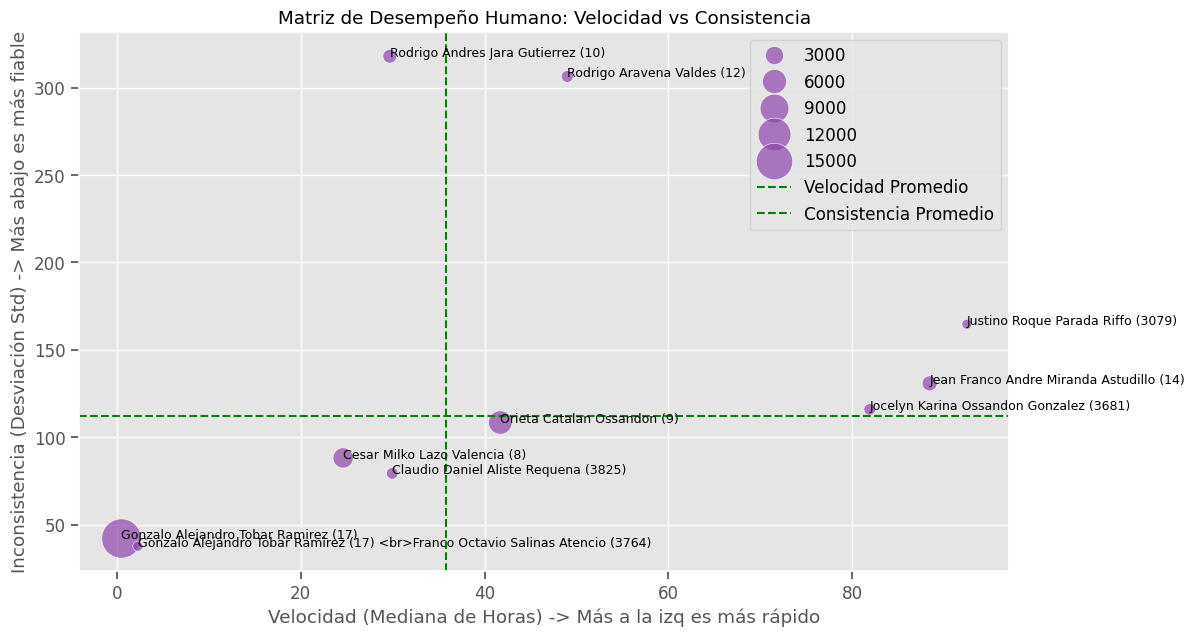

In [ ]:
#Analisis de RRHH, calidad y consistencia

ingenieros_no_infra = ["Andre Maltes Arancibia (15)",
                       "Boris Patricio Tapia Pena (3726)",
                       "Carla Baeza Navarro (2695)",
                       "Diego Mauricio Hernandez Buitrago (2219)",
                       "Esteban Francisco Cartes Riffo (4017)",
                       "Felipe Andres Veloz Maureira (1798)",
                       "Fernando Adrian Silva Leon (1819)",
                       "Fernando Basilio Layana Layana (3899)",
                       "Fernando Basilio Layana Layana (3899) <br>Esteban Francisco Cartes Riffo (4017)",
                       "Gabriel Natan Pizarro Herrera (1704)",
                       "Grupo Operaciones Valpo (1698)"
                       ]

#kpi de recursos humnanos
kpi_hr = df_infra.groupby('asignado_a__tecnico').agg(
    Volumen=('id', 'count'),
    Velocidad_Mediana=('tiempo_vida_horas', 'median'),
    Consistencia_Std=('tiempo_vida_horas', 'std') # Menor std = Más predecible
).dropna()

# Se consideran >30 ticket resueltos por ingeniero para no ensuciar la data
kpi_hr = kpi_hr[kpi_hr['Volumen'] > 30]

#eliminamos ingenieros no del area
kpi_hr = kpi_hr.drop(ingenieros_no_infra)

#grafico
plt.figure(figsize=(12, 7))
sns.scatterplot(data=kpi_hr, x='Velocidad_Mediana', y='Consistencia_Std', 
                size='Volumen', sizes=(50, 800), alpha=0.7, color='#8e44ad')

for i in range(kpi_hr.shape[0]):
    row = kpi_hr.iloc[i]
    # Etiquetas
    if row['Velocidad_Mediana'] < kpi_hr['Velocidad_Mediana'].quantile(0.5) or \
       row['Velocidad_Mediana'] > kpi_hr['Velocidad_Mediana'].quantile(0.5) or \
       row['Consistencia_Std'] > kpi_hr['Consistencia_Std'].quantile(0.9):
        plt.text(row['Velocidad_Mediana'], row['Consistencia_Std'], kpi_hr.index[i], fontsize=9)

plt.title('Matriz de Desempeño Humano: Velocidad vs Consistencia')
plt.xlabel('Velocidad (Mediana de Horas) -> Más a la izq es más rápido')
plt.ylabel('Inconsistencia (Desviación Std) -> Más abajo es más fiable')
plt.axvline(kpi_hr['Velocidad_Mediana'].median(), color='green', linestyle='--', label='Velocidad Promedio')
plt.axhline(kpi_hr['Consistencia_Std'].median(), color='green', linestyle='--', label='Consistencia Promedio')
plt.legend()
plt.show()

/tmp/ipykernel_274741/2049365066.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perfil_horario.index, y=perfil_horario.values, palette='mako')


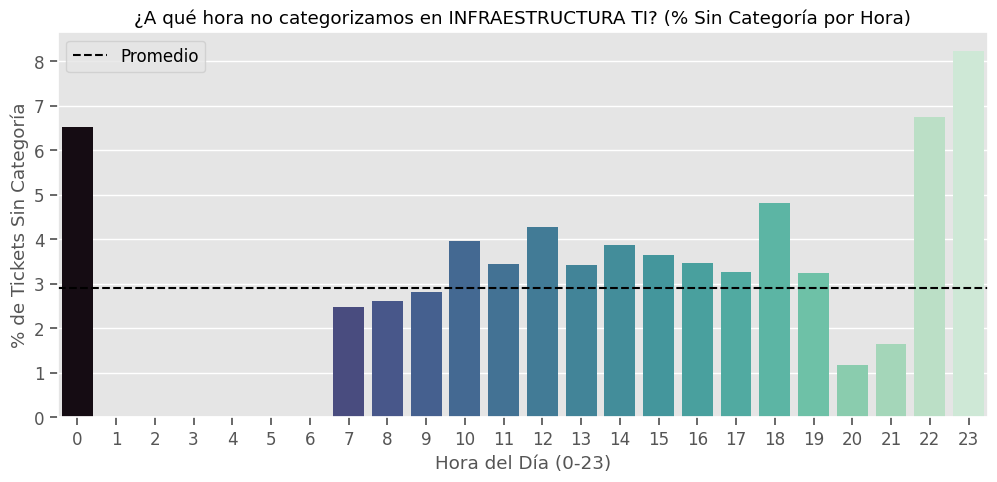

/tmp/ipykernel_274741/2049365066.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perfil_horario.index, y=perfil_horario.values, palette='mako')


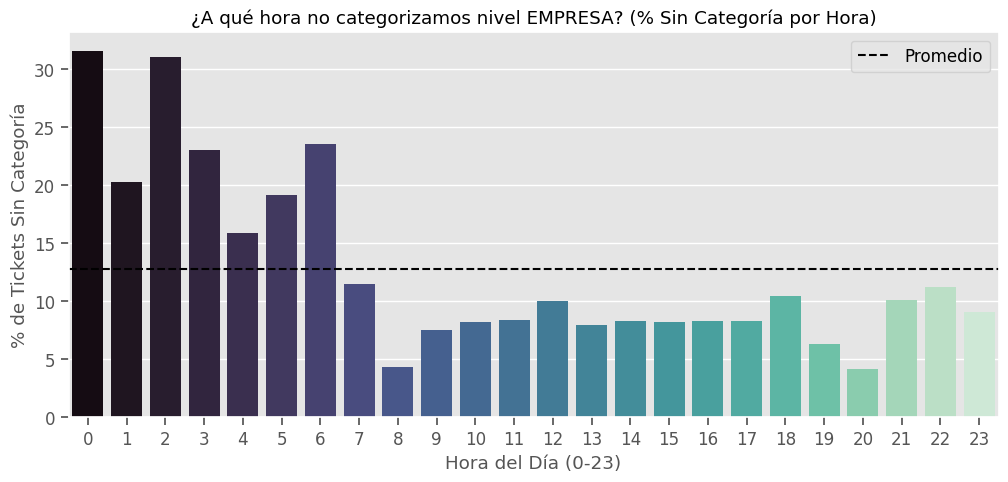

In [ ]:
#relacion temporal de los Sin Categoria
#¿La gente deja de categorizar cuando está cansada (noche) o quiere irse (viernes)?

#% Sin Categoria por Hora del dia
perfil_horario = df_infra.groupby(["fecha_de_apertura_hora"])["es_sin_categoria"].mean() * 100

plt.Subplot()

#histograma
plt.figure(figsize=(12, 5))
sns.barplot(x=perfil_horario.index, y=perfil_horario.values, palette='mako')
plt.title('¿A qué hora no categorizamos en INFRAESTRUCTURA TI? (% Sin Categoría por Hora)')
plt.xlabel('Hora del Día (0-23)')
plt.ylabel('% de Tickets Sin Categoría')
plt.axhline(perfil_horario.mean(), color='black', linestyle='--', label='Promedio')
plt.legend()
plt.show()

#% Sin Categoria por Hora del dia GLOBAL
perfil_horario = df_all.groupby(["fecha_de_apertura_hora"])["es_sin_categoria"].mean() * 100

#histograma
plt.figure(figsize=(12, 5))
sns.barplot(x=perfil_horario.index, y=perfil_horario.values, palette='mako')
plt.title('¿A qué hora no categorizamos nivel EMPRESA? (% Sin Categoría por Hora)')
plt.xlabel('Hora del Día (0-23)')
plt.ylabel('% de Tickets Sin Categoría')
plt.axhline(perfil_horario.mean(), color='black', linestyle='--', label='Promedio')
plt.legend()
plt.show()

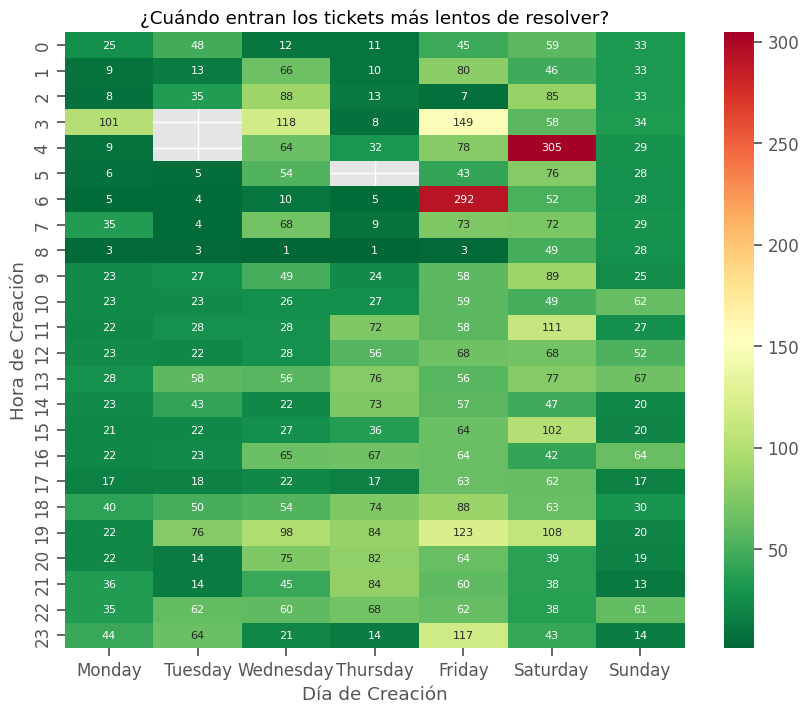

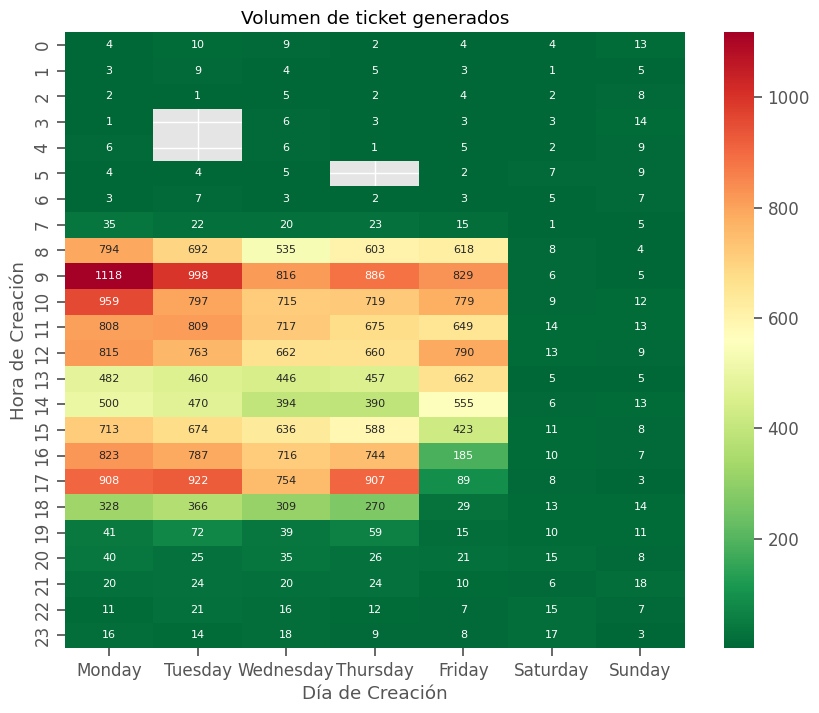

In [62]:
#tiempos de resolucion con heatmap
heatmap_data = df_infra.pivot_table(
    index='fecha_de_apertura_hora', 
    columns='weekday', 
    values='tiempo_vida_horas', 
    aggfunc='median'
)

#volumen de ticket generados en infra TI
heatmap_data_count = df_infra.pivot_table(
    index='fecha_de_apertura_hora', 
    columns='weekday', 
    values='id', 
    aggfunc='count'
)

dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[dias_orden]
heatmap_data_count = heatmap_data_count[dias_orden]


#heatmap1
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=True, fmt=".0f", annot_kws={"size":8}) # Rojo = Lento, Verde = Rápido
plt.title('¿Cuándo entran los tickets más lentos de resolver?')
plt.xlabel('Día de Creación')
plt.ylabel('Hora de Creación')
plt.show()

#heatmap2
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_count, cmap='RdYlGn_r', annot=True, fmt=".0f", annot_kws={"size":8}) # Rojo = Lento, Verde = Rápido
plt.title('Volumen de ticket generados')
plt.xlabel('Día de Creación')
plt.ylabel('Hora de Creación')
plt.show()



In [65]:
df_infra["prioridad"].unique()

<StringArray>
['Media', 'Alta', 'Muy alta', 'Mayor', 'Baja', 'Muy baja']
Length: 6, dtype: str

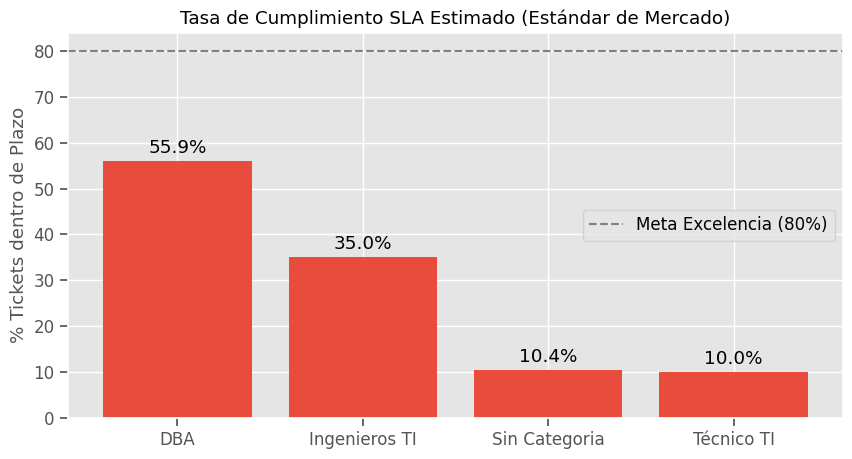

In [67]:
#SLA
def definir_meta_sla(prioridad):
    p = str(prioridad).lower()
    if "mayor" in p: return 2
    if 'alta' in p or 'critica' in p: return 12
    if 'media' in p: return 24
    return 48

df_infra["metas_sla_horas"] = df_infra["prioridad"].apply(definir_meta_sla)
df_infra["cumple_SLA"] = df_infra["tiempo_vida_horas"] <= df_infra["metas_sla_horas"]

tasa_cumplimiento = df_infra.groupby("area")["cumple_SLA"].mean() * 100

#grafico
plt.figure(figsize=(10, 5))
colores = ['#27ae60' if x >= 80 else '#f39c12' if x >= 60 else '#e74c3c' for x in tasa_cumplimiento.values]
bars = plt.bar(tasa_cumplimiento.index, tasa_cumplimiento.values, color=colores)

plt.title('Tasa de Cumplimiento SLA Estimado (Estándar de Mercado)')
plt.ylabel('% Tickets dentro de Plazo')
plt.axhline(80, color='grey', linestyle='--', label='Meta Excelencia (80%)')
plt.bar_label(bars, fmt='%.1f%%', padding=3)
plt.legend()
plt.show()

In [68]:
df_infra.info()

<class 'pandas.DataFrame'>
Index: 36443 entries, 4 to 109797
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            36443 non-null  int64         
 1   id                                    36443 non-null  int64         
 2   titulo                                36443 non-null  str           
 3   estado                                36443 non-null  str           
 4   ultima_modificacion                   36443 non-null  datetime64[us]
 5   fecha_de_apertura                     36443 non-null  datetime64[us]
 6   prioridad                             36443 non-null  str           
 7   solicitante__solicitante              36331 non-null  str           
 8   asignado_a__grupo_de_tecnicos         36234 non-null  str           
 9   asignado_a__tecnico                   34483 non-null  str           
 10  categoria    

(Top 5% mas lentos de Outliers: > 215.7 horas
Cantidad de tickets extremos: 1823

Top 5 Usuarios con más tickets 'Eternos':
solicitante__solicitante
Nellyda Pia Ferreira Gomez (7)              95
Sebastian Rodriguez Corvalan (226)          90
Diego Mauricio Hernandez Buitrago (2219)    86
Jose Estefano Maturana Escudero (1404)      45
Andre Maltes Arancibia (15)                 39
Name: count, dtype: int64


/tmp/ipykernel_274741/2113011056.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(conteos), y=list(conceptos), palette='mako')


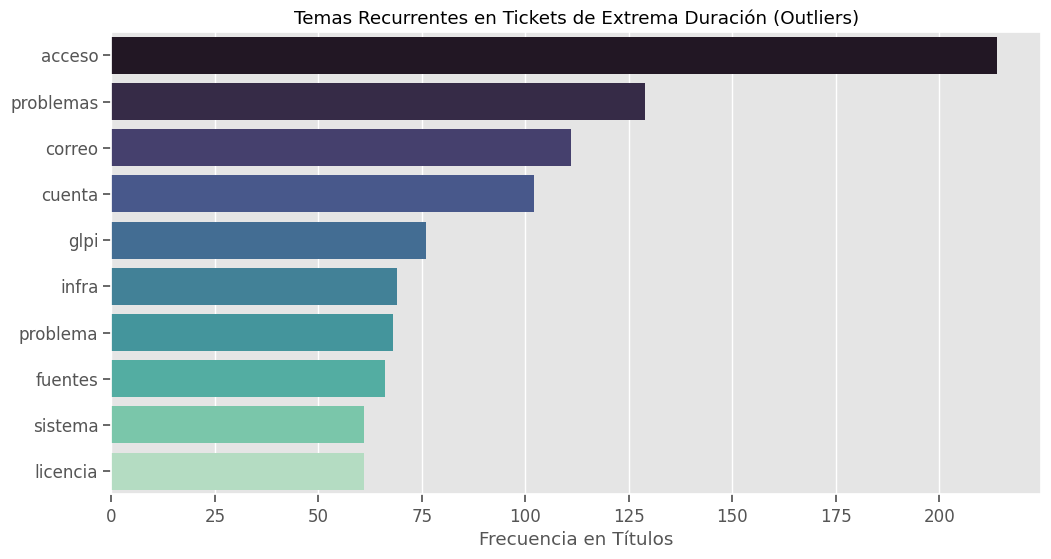

In [ ]:
#analisis de outliers (top 5% mas lento)

#Analisis de patrones de titulos (NLP basico)
def extraer_tokens(textos):
    palabras_ignoradas = ['re:', 'rv:', 'ticket', 'solicitud', 'de', 'el', 'la', 'en', 'para', 'con', 'infraestructura']
    todos_tokens = []
    for t in textos:
        if isinstance(t, str):
            clean = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ ]', '', t.lower())
            tokens = [w for w in clean.split() if w not in palabras_ignoradas and len(w)>3]
            todos_tokens.extend(tokens)
    return Counter(todos_tokens).most_common(10)

#historico
umbral_outlier = df_infra['tiempo_vida_horas'].quantile(0.95)
df_outliers = df_infra[df_infra['tiempo_vida_horas'] > umbral_outlier].copy()

print(f"(Top 5% mas lentos de Outliers: > {umbral_outlier:.1f} horas")
print(f"Cantidad de tickets extremos: {len(df_outliers)}")

if 'solicitante__solicitante' in df_outliers.columns:
    top_solicitantes = df_outliers['solicitante__solicitante'].value_counts().head(5)
    print("\nTop 5 Usuarios con más tickets 'Eternos':")
    print(top_solicitantes)

top_conceptos = extraer_tokens(df_outliers['titulo'])

# histograma de conceptos frecuentes
conceptos, conteos = zip(*top_conceptos)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(conteos), y=list(conceptos), palette='mako')
plt.title('Temas Recurrentes en Tickets de Extrema Duración (Outliers)')
plt.xlabel('Frecuencia en Títulos')
plt.show()

#2025
umbral_outlier = df_infra[df_infra["fecha_de_apertura_año"] == 2025]['tiempo_vida_horas'].quantile(0.95)
df_outliers = df_infra[df_infra['tiempo_vida_horas'] > umbral_outlier].copy()

print(f"(Top 5% mas lentos de Outliers 2025: > {umbral_outlier:.1f} horas")
print(f"Cantidad de tickets extremos 2025: {len(df_outliers)}")

if 'solicitante__solicitante' in df_outliers.columns:
    top_solicitantes = df_outliers['solicitante__solicitante'].value_counts().head(5)
    print("\nTop 5 Usuarios con más tickets 'Eternos' 2025:")
    print(top_solicitantes)

top_conceptos = extraer_tokens(df_outliers['titulo'])

# histograma de conceptos frecuentes
conceptos, conteos = zip(*top_conceptos)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(conteos), y=list(conceptos), palette='mako')
plt.title('Temas Recurrentes en Tickets de Extrema Duración (Outliers) 2025')
plt.xlabel('Frecuencia en Títulos')
plt.show()